In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from multiprocessing import cpu_count

import torch
import imageio
import sys
import os
from PIL import Image
from IPython.display import display, Markdown, Latex

#print(f'python version: {sys.version}')
#print(f'torch version: {torch.__version__}')

# Test

In [2]:
train_df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv', index_col='Id')

In [3]:
train_df

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
Id,,,,,,,,,,,,,
0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20


# Train

Use the train DataFrame with a cat/dog classification from [this](https://www.kaggle.com/markwijkhuizen/petfinder-eda-yolov5-obj-detection-tfrecords) notebook.

In [4]:
# Train DataFrame with YOLOV5 info
train = pd.read_pickle('/kaggle/input/petfinder-yolov5-kfold-tfrecords/train.pkl')

In [5]:
display(train.head())

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,Pawpularity,file_path,n_pets,label,coords,x_min,x_max,y_min,y_max,pet_ratio
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,63,/kaggle/input/petfinder-pawpularity-score/trai...,3,dog,"[(120.58594, 114.75, 325.125, 474.75), (202.21...",202.21875,32.062500,114.750000,229.218750,0.346914
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,42,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(649.03125, 198.13593, 886.0687, 476.49374)]",649.03125,886.068726,198.135925,476.493744,0.082485
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,28,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(110.4375, 63.75, 575.25, 684.75)]",110.43750,575.250000,63.750000,684.750000,0.417773
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,15,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(0.5625, 217.40625, 404.15625, 559.96875)]",0.56250,404.000000,217.406250,559.968750,0.473827
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,72,/kaggle/input/petfinder-pawpularity-score/trai...,2,dog,"[(51.1875, 218.625, 513.0, 651.375), (142.875,...",142.87500,513.000000,218.625000,377.625000,0.558559


In [6]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9912 non-null   string 
 1   Subject Focus  9912 non-null   uint8  
 2   Eyes           9912 non-null   uint8  
 3   Face           9912 non-null   uint8  
 4   Near           9912 non-null   uint8  
 5   Action         9912 non-null   uint8  
 6   Accessory      9912 non-null   uint8  
 7   Group          9912 non-null   uint8  
 8   Collage        9912 non-null   uint8  
 9   Human          9912 non-null   uint8  
 10  Occlusion      9912 non-null   uint8  
 11  Info           9912 non-null   uint8  
 12  Blur           9912 non-null   uint8  
 13  Pawpularity    9912 non-null   uint8  
 14  file_path      9912 non-null   object 
 15  n_pets         9912 non-null   int64  
 16  label          9912 non-null   object 
 17  coords         9912 non-null   object 
 18  x_min   

None

In [7]:
train.to_csv('yolotrain.csv')

# Cat/Dog/Unknown Mean Pawpularity Scores

In [8]:
# Cat/Dog/Unknown distribution
display(train['label'].value_counts(normalize=True).to_frame() * 100)

,label
cat,53.379742
dog,46.337772
unknown,0.282486


In [9]:
count_df = train.groupby(['label'])['label'].count()
count_df = count_df.to_frame()
count_df = count_df.rename(columns={"label": "label", "label": "counts"})
count_df = count_df.reset_index()
count_df

,label,counts
0,cat,5291
1,dog,4593
2,unknown,28


# Pie Graph

In [10]:
import plotly.graph_objects as go

labels = count_df['label'] 
#values = [4500, 2500, 1053, 500]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=count_df['label'] , 
                             values=count_df['counts'], 
                             hole=.70)])
fig.update_layout(
    #autosize=False,
    width=600,
    height=400,
    title="Pie Graph for Cats and Dogs Counts"
)

fig.show()

This next cell shows what this notebook is all about. Dogs have on average a Pawpularity score of 42.10, whereas cats only have an average Pawpularity score of 34.52.

In [11]:
# Mean Pawpularity scores per pet
DOG_MEAN = train.loc[train['label'] == 'dog', 'Pawpularity'].mean()
CAT_MEAN = train.loc[train['label'] == 'cat', 'Pawpularity'].mean()
GLOBAL_MEAN = train['Pawpularity'].mean()

# Dogs seem to be more Pawpular than cats on average
print(f'DOG_MEAN: {DOG_MEAN:.2f}, CAT_MEAN: {CAT_MEAN:.2f}, GLOBAL_MEAN: {GLOBAL_MEAN:.2f}')

DOG_MEAN: 42.10, CAT_MEAN: 34.52, GLOBAL_MEAN: 38.04


The next histogram clearly shows cats have a lower Pawpularity score. The most surprising observation is the large amount of dogs having a Pawpularity score of near 100.

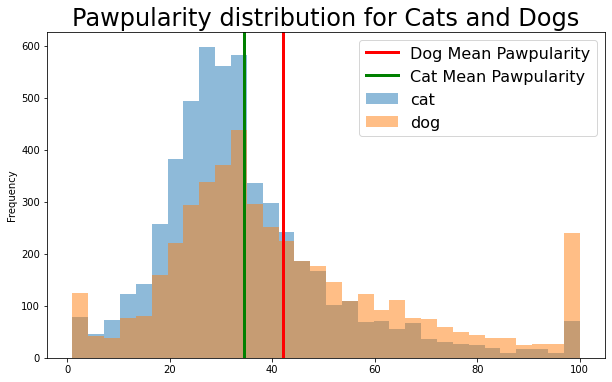

In [12]:
# Plot Pawpularity distribution for cats and dogs
plt.figure(figsize=(10, 6))
plt.title('Pawpularity distribution for Cats and Dogs', size=24)
plt.axvline(DOG_MEAN, c='red', ls='-', lw=3, label='Dog Mean Pawpularity')
plt.axvline(CAT_MEAN, c='green', ls='-', lw=3, label='Cat Mean Pawpularity')
train.loc[train['label'] != 'unknown'].groupby('label')['Pawpularity'].plot(kind='hist', bins=32, alpha=0.50)
plt.legend(prop={'size': 16})
pass

In [13]:
train

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,Pawpularity,file_path,n_pets,label,coords,x_min,x_max,y_min,y_max,pet_ratio
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,63,/kaggle/input/petfinder-pawpularity-score/trai...,3,dog,"[(120.58594, 114.75, 325.125, 474.75), (202.21...",202.21875,32.062500,114.750000,229.218750,0.346914
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,42,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(649.03125, 198.13593, 886.0687, 476.49374)]",649.03125,886.068726,198.135925,476.493744,0.082485
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,28,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(110.4375, 63.75, 575.25, 684.75)]",110.43750,575.250000,63.750000,684.750000,0.417773
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,15,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(0.5625, 217.40625, 404.15625, 559.96875)]",0.56250,404.000000,217.406250,559.968750,0.473827
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,72,/kaggle/input/petfinder-pawpularity-score/trai...,2,dog,"[(51.1875, 218.625, 513.0, 651.375), (142.875,...",142.87500,513.000000,218.625000,377.625000,0.558559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,...,15,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(13.5, 58.125, 722.25, 837.0)]",13.50000,722.250000,58.125000,837.000000,0.731964
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,...,70,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(218.0625, 169.875, 669.75, 725.625)]",218.06250,669.750000,169.875000,725.625000,0.362784
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,...,20,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(0.0, 12.95, 629.4, 889.0)]",0.00000,629.400024,12.950000,889.000000,0.884572
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,...,20,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(228.1875, 148.5, 660.75, 772.5)]",228.18750,660.750000,148.500000,772.500000,0.390000


In [14]:
FEATURES = [
        'Subject Focus', 
        'Eyes', 
        'Face', 
        'Near', 
        'Action', 
        'Accessory', 
        'Group', 
        'Collage', 
        'Human', 
        'Occlusion', 
        'Info', 
        'Blur'
    ]
TARGET = 'Pawpularity'

In [15]:
# seperate dog and cat analysis
dog = train.loc[train['label'] == 'dog']
dog

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,Pawpularity,file_path,n_pets,label,coords,x_min,x_max,y_min,y_max,pet_ratio
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,63,/kaggle/input/petfinder-pawpularity-score/trai...,3,dog,"[(120.58594, 114.75, 325.125, 474.75), (202.21...",202.218750,32.062500,114.750000,229.21875,0.346914
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,28,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(110.4375, 63.75, 575.25, 684.75)]",110.437500,575.250000,63.750000,684.75000,0.417773
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,15,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(0.5625, 217.40625, 404.15625, 559.96875)]",0.562500,404.000000,217.406250,559.96875,0.473827
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,72,/kaggle/input/petfinder-pawpularity-score/trai...,2,dog,"[(51.1875, 218.625, 513.0, 651.375), (142.875,...",142.875000,513.000000,218.625000,377.62500,0.558559
5,001dd4f6fafb890610b1635f967ea081,0,0,1,0,0,0,0,0,0,...,74,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(179.625, 333.375, 439.5, 541.125)]",179.625000,439.500000,333.375000,541.12500,0.104321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9903,ff903858a9899465ee4cd17e942bef24,0,1,1,0,0,0,0,0,1,...,51,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(163.59375, 168.5625, 525.75, 510.0)]",163.593750,525.750000,168.562500,510.00000,0.179115
9904,ff9b3b3468c4b35a3b6450a1ddc88449,0,1,1,1,0,0,0,0,0,...,44,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(77.987114, 9.264453, 432.03946, 603.9422)]",77.987114,432.039459,9.264453,603.94220,0.667283
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,...,70,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(218.0625, 169.875, 669.75, 725.625)]",218.062500,669.750000,169.875000,725.62500,0.362784
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,...,20,/kaggle/input/petfinder-pawpularity-score/trai...,1,dog,"[(228.1875, 148.5, 660.75, 772.5)]",228.187500,660.750000,148.500000,772.50000,0.390000


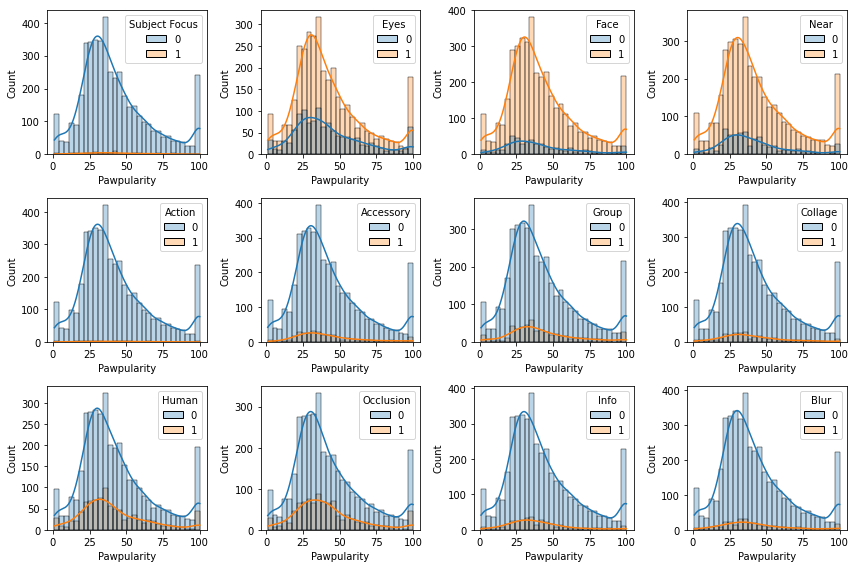

In [16]:
import seaborn as sns
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

for f, ax in zip(FEATURES, axes.flatten()):
    sns.histplot(
        data=dog,
        x=TARGET,
        bins=30,
        hue=f,
        legend=True,
        kde=True,
        ax=ax,
        alpha=0.3)

fig.tight_layout()    
plt.show()

In [17]:
cat = train.loc[train['label'] == 'cat']
cat

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,Pawpularity,file_path,n_pets,label,coords,x_min,x_max,y_min,y_max,pet_ratio
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,42,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(649.03125, 198.13593, 886.0687, 476.49374)]",649.031250,886.068726,198.135925,476.493744,0.082485
8,0042bc5bada6d1cf8951f8f9f0d399fa,0,1,1,1,0,0,0,0,0,...,53,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(1.875, 5.25, 656.625, 953.25)]",1.875000,656.625000,5.250000,953.250000,0.898351
9,0049cb81313c94fa007286e9039af910,0,1,1,1,0,0,0,0,0,...,21,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(9.9921875, 2.8289056, 1231.0375, 842.67224)]",9.992188,1231.037476,2.828906,842.672241,0.947538
10,005017716086b8d5e118dd9fe26459b1,0,1,1,1,0,0,0,0,0,...,28,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(323.25, 74.5, 995.0, 1252.0)]",323.250000,995.000000,74.500000,1252.000000,0.483164
12,00630b1262efe301cb15a3b2022ba744,0,1,1,1,0,0,0,0,0,...,18,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(126.5625, 293.625, 510.75, 715.125)]",126.562500,510.750000,293.625000,715.125000,0.312593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9902,ff78a56d5e0029cd6288c62f7b7f10e5,0,1,1,1,0,0,0,0,0,...,50,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(539.0, 322.25, 909.0, 858.0)]",539.000000,909.000000,322.250000,858.000000,0.166242
9905,ffaf7bf7e64b9eecaf02fc2c14d6b654,0,1,1,1,0,0,0,0,0,...,31,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(134.5, 0.0, 1276.0, 743.5)]",134.500000,1276.000000,0.000000,743.500000,0.777134
9906,ffb8b466494a3e48bcb874a2fe9b976d,0,1,1,1,0,0,0,0,0,...,31,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(377.94922, 11.666992, 684.35547, 436.04688)]",377.949219,684.355469,11.666992,436.046875,0.265639
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,...,15,/kaggle/input/petfinder-pawpularity-score/trai...,1,cat,"[(13.5, 58.125, 722.25, 837.0)]",13.500000,722.250000,58.125000,837.000000,0.731964


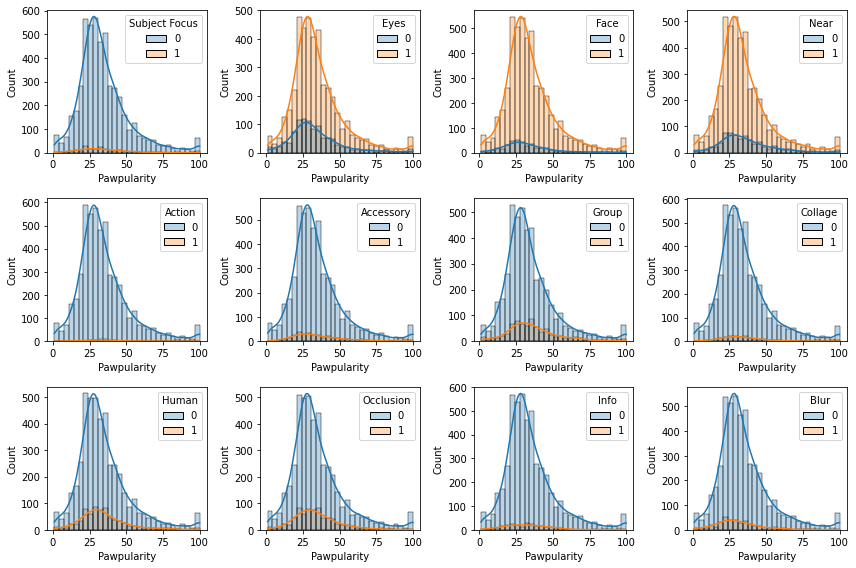

In [18]:
import seaborn as sns
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

for f, ax in zip(FEATURES, axes.flatten()):
    sns.histplot(
        data=cat,
        x=TARGET,
        bins=30,
        hue=f,
        legend=True,
        kde=True,
        ax=ax,
        alpha=0.3)

fig.tight_layout()    
plt.show()

# Plot Pet Photos

In [19]:
image_folder = '/kaggle/input/petfinder-pawpularity-score/train'
def plot_images(data, nrows=5, ncols=5, figsize=(15, 15)):

    indices = data.sample(nrows * ncols).index
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for index, ax in zip(indices, axes.flatten()):
        img_path = os.path.join(image_folder, '{}.jpg'.format(index))
        img = Image.open(img_path)
        img = img.resize((128,128))
        ax.imshow(img)
        ax.set_title(train_df.loc[index][TARGET], fontsize=18)

    fig.tight_layout()
    plt.show()

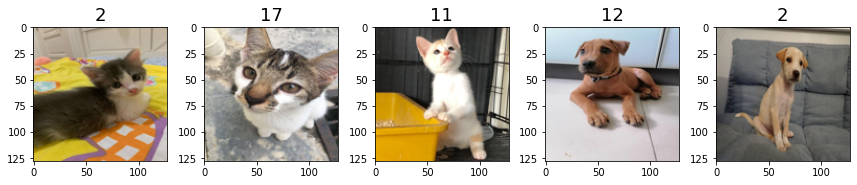

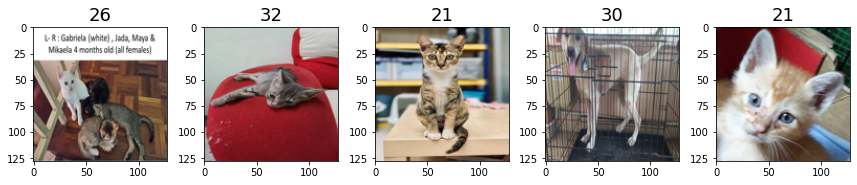

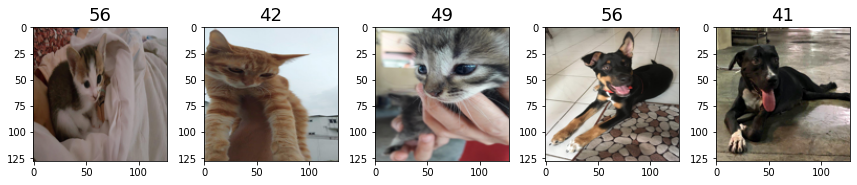

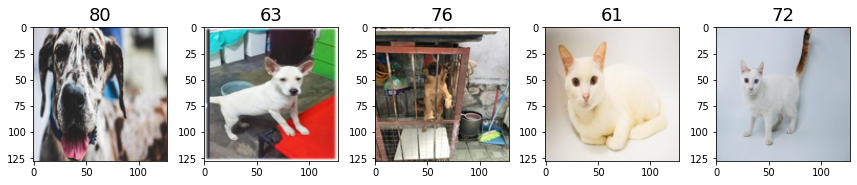

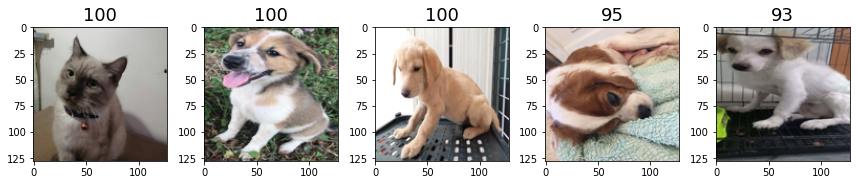

In [20]:
pawpularity_range = [0, 20, 40, 60, 80, 100]
query = lambda i: '{} < Pawpularity and Pawpularity <= {}'.format(pawpularity_range[i], pawpularity_range[i+1])
for i in range(0, 5):
    df = train_df.query(query(i))
    plot_images(df, nrows=1, ncols=5, figsize=(12, 5))

# Using YOLOV5 to classify cats and dogs 

In [23]:
# Hacky way of loading YOLOV5 offline, don't try this at home

# Add YOLOV5 master to cache
!cp -R '/kaggle/input/yolov5/torch/root/.cache/torch' '/root/.cache/torch'
# Add Ultralytics (whatever this is) to the config folder
!cp -R '/kaggle/input/yolov5/ultralytics/root/.config/Ultralytics' '/root/.config/Ultralytics'

In [22]:
# Load Best Performing YOLOV5X Model
yolov5x6_model = torch.hub.load('ultralytics/yolov5', 'yolov5x6')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


In [24]:
self_test = pd.read_csv('/kaggle/input/590paw/test.csv')

In [25]:
self_test 

,Id,true_label,file_path
0,IMG_0969.JPG,0,/kaggle/input/own-tests/IMG_0969.JPG
1,IMG_0982.JPG,1,/kaggle/input/own-tests/IMG_0982.JPG
2,IMG_0983.JPG,1,/kaggle/input/own-tests/IMG_0983.JPG
3,IMG_0968.JPG,0,/kaggle/input/own-tests/IMG_0968.JPG
4,IMG_0981.JPG,1,/kaggle/input/own-tests/IMG_0981.JPG
5,IMG_0980.JPG,1,/kaggle/input/own-tests/IMG_0980.JPG
6,IMG_0984.JPG,1,/kaggle/input/own-tests/IMG_0984.JPG
7,IMG_0985.JPG,1,/kaggle/input/own-tests/IMG_0985.JPG
8,IMG_0978.JPG,0,/kaggle/input/own-tests/IMG_0978.JPG
9,IMG_0979.JPG,1,/kaggle/input/own-tests/IMG_0979.JPG


In [51]:
def get_pet_label(file_path):
    # Read Image
    image = imageio.imread(file_path)

    # Get YOLOV5 results using Test Time Augmentation for better result
    results = yolov5x6_model(image, augment=True)
   
    #plt.figure()
    #plt.imshow(image)
    # Save info for each pet
    for x1, y1, x2, y2, treshold, label_int in results.xyxy[0].cpu().detach().numpy():
        # Map integer encoded label to label
        label = results.names[int(label_int)]
        # Objects detected are already sorted on confidence, return first cat or dog
        if label in ['cat', 'dog']:
            return label
        
    # Could not detect pet, "unknown" label
    return 'unknown'

# Precitions

In [78]:
plot_df = self_test[20:]
plot_df

,Id,true_label,file_path,pred_label
20,WechatIMG826.JPG,1,/kaggle/input/own-tests/WechatIMG826.JPG,cat
21,IMG_0972.JPG,1,/kaggle/input/own-tests/IMG_0972.JPG,cat
22,IMG_0973.JPG,1,/kaggle/input/own-tests/IMG_0973.JPG,cat
23,WechatIMG823.JPG,1,/kaggle/input/own-tests/WechatIMG823.JPG,cat
24,IMG_0967.JPG,0,/kaggle/input/own-tests/IMG_0967.JPG,dog
25,IMG_0971.JPG,0,/kaggle/input/own-tests/IMG_0971.JPG,dog
26,WechatIMG821.JPG,0,/kaggle/input/own-tests/WechatIMG821.JPG,dog
27,IMG_8451.JPG,0,/kaggle/input/own-tests/IMG_8451.JPG,dog
28,IMG_0970.JPG,0,/kaggle/input/own-tests/IMG_0970.JPG,dog


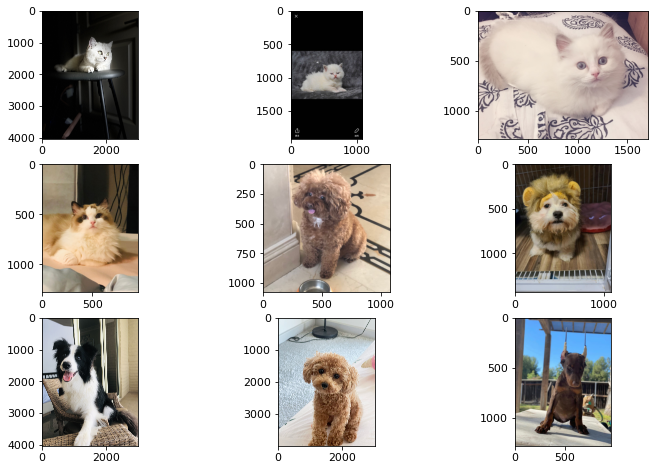

In [87]:
fig, axs = plt.subplots(3,3,figsize=(12, 8))
for idx, row in plot_df.iterrows(): 
    i = (idx-20)//3
    j = (idx-20) % 3
    file_path = row['file_path']
    image = imageio.imread(file_path)
    #image = np.resize(image,(128,128))
    axs[i,j].imshow(image)

In [61]:
# Submission dictionary to create DataFrame from
pred_label = []
for pet_id, file_path in tqdm(self_test[['Id', 'file_path']].itertuples(index=False), total=len(self_test)):
    label = get_pet_label(file_path)
    image = imageio.imread(file_path)    
    pred_label.append(label)

  0%|          | 0/29 [00:00<?, ?it/s]

In [34]:
self_test ['pred_label'] = pred_label

In [35]:
self_test

,Id,true_label,file_path,pred_label
0,IMG_0969.JPG,0,/kaggle/input/own-tests/IMG_0969.JPG,dog
1,IMG_0982.JPG,1,/kaggle/input/own-tests/IMG_0982.JPG,cat
2,IMG_0983.JPG,1,/kaggle/input/own-tests/IMG_0983.JPG,cat
3,IMG_0968.JPG,0,/kaggle/input/own-tests/IMG_0968.JPG,dog
4,IMG_0981.JPG,1,/kaggle/input/own-tests/IMG_0981.JPG,cat
5,IMG_0980.JPG,1,/kaggle/input/own-tests/IMG_0980.JPG,cat
6,IMG_0984.JPG,1,/kaggle/input/own-tests/IMG_0984.JPG,cat
7,IMG_0985.JPG,1,/kaggle/input/own-tests/IMG_0985.JPG,cat
8,IMG_0978.JPG,0,/kaggle/input/own-tests/IMG_0978.JPG,dog
9,IMG_0979.JPG,1,/kaggle/input/own-tests/IMG_0979.JPG,cat


In [88]:
count_df = self_test.groupby(['pred_label'])['pred_label'].count()
count_df = count_df.to_frame()
count_df = count_df.rename(columns={"pred_label": "label", "pred_label": "counts"})
count_df = count_df.reset_index()
count_df

,pred_label,counts
0,cat,15
1,dog,14


In [90]:
import plotly.graph_objects as go

labels = count_df['pred_label'] 
#values = [4500, 2500, 1053, 500]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=count_df['pred_label'] , 
                             values=count_df['counts'], 
                             hole=.70)])
fig.update_layout(
    #autosize=False,
    width=600,
    height=400,
    title="Pie Graph for Cats and Dogs Counts"
)

fig.show()

In [91]:
self_test.to_csv('yolov5.csv')